In [ ]:
import glob
import os
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from acvp_functions import *
%load_ext autoreload
%autoreload 2

folder = r'\\tudelft.net\staff-umbrella\EURECCA\fieldvisits\20231101_ripples_frame\ublab-3c\dep1\raw_netcdf'
filez = glob.glob(os.path.join(folder, '*.nc'))

plotFilePath = r'\\tudelft.net\staff-umbrella\EURECCA\Floris\vanMarlies\reconstruct\fig'

In [2]:
tvalid1 = pd.to_datetime('2023-11-02 00:00') 
tvalid2 = pd.to_datetime('2023-11-02 02:20')

In [3]:
recompute = True

if recompute is False:
    ublab = xr.open_dataset(r'\\tudelft.net\staff-umbrella\EURECCA\01AnalyseRemote\data\ublab\ublab_30deg.nc')
else:
    snrmin = 2

    umlist = []; vmlist = []; wmlist = []; w2mlist = []; uurmlist = []; vurmlist = []; wurmlist = []; w2urmlist = []
    for file in filez[14:-3]:
        print(file)
        ds = load_adcv_corrected(file, thet1=-30, thet2=0)  

        # compute mean velocities 
        um = ds.ur.where(ds.snr1>snrmin).where(ds.snr2>snrmin).coarsen(time=51*60*5, boundary='trim').mean()
        wm = ds.w1r.where(ds.snr1>snrmin).where(ds.snr2>snrmin).coarsen(time=51*60*5, boundary='trim').mean()
        vm = ds.vr.where(ds.snr3>snrmin).where(ds.snr4>snrmin).coarsen(time=51*60*5, boundary='trim').mean()    
        w2m = ds.w2r.where(ds.snr3>snrmin).where(ds.snr4>snrmin).coarsen(time=51*60*5, boundary='trim').mean()
        uurm = ds.u.where(ds.snr1>snrmin).where(ds.snr2>snrmin).coarsen(time=51*60*5, boundary='trim').mean()
        wurm = ds.w1.where(ds.snr1>snrmin).where(ds.snr2>snrmin).coarsen(time=51*60*5, boundary='trim').mean() 
        vurm = ds.v.where(ds.snr3>snrmin).where(ds.snr4>snrmin).coarsen(time=51*60*5, boundary='trim').mean()   
        w2urm = ds.w2.where(ds.snr3>snrmin).where(ds.snr4>snrmin).coarsen(time=51*60*5, boundary='trim').mean()  

        umlist.append(um)
        vmlist.append(vm)
        wmlist.append(wm)  
        w2mlist.append(w2m)  
        uurmlist.append(uurm)
        vurmlist.append(vurm)
        wurmlist.append(wurm)  
        w2urmlist.append(w2urm)

    um = xr.concat(umlist, dim='time')
    ublab = xr.Dataset(data_vars = {}, coords = um.coords)
    ublab['um'] = xr.concat(umlist, dim='time')
    ublab['vm'] = xr.concat(vmlist, dim='time')
    ublab['wm'] = xr.concat(wmlist, dim='time')  
    ublab['w2m'] = xr.concat(w2mlist, dim='time')  
    ublab['uurm'] = xr.concat(uurmlist, dim='time')
    ublab['vurm'] = xr.concat(vurmlist, dim='time')
    ublab['wurm'] = xr.concat(wurmlist, dim='time')  
    ublab['w2urm'] = xr.concat(w2urmlist, dim='time')  

    # ublab.to_netcdf(r'\\tudelft.net\staff-umbrella\EURECCA\01AnalyseRemote\data\ublab\ublab_30deg.nc')


\\tudelft.net\staff-umbrella\EURECCA\fieldvisits\20231101_ripples_frame\ublab-3c\dep1\raw_netcdf\dep1_14.nc
\\tudelft.net\staff-umbrella\EURECCA\fieldvisits\20231101_ripples_frame\ublab-3c\dep1\raw_netcdf\dep1_15.nc
\\tudelft.net\staff-umbrella\EURECCA\fieldvisits\20231101_ripples_frame\ublab-3c\dep1\raw_netcdf\dep1_16.nc
\\tudelft.net\staff-umbrella\EURECCA\fieldvisits\20231101_ripples_frame\ublab-3c\dep1\raw_netcdf\dep1_17.nc
\\tudelft.net\staff-umbrella\EURECCA\fieldvisits\20231101_ripples_frame\ublab-3c\dep1\raw_netcdf\dep1_18.nc


In [4]:
adv = xr.open_dataset(r'\\tudelft.net\staff-umbrella\EURECCA\fieldvisits\20231101_ripples_frame\vec008\tailored15min_uc2_v2\vec008.nc')
adv = adv.rename({'t': 'time'}).sel(time=slice(ublab.time.min(), ublab.time.max()+pd.to_timedelta('2H')))

In [5]:
ublab_rms = load_urms_ublab(snrmin=2, thet1=-30, thet2=0, recompute=False)
adv_rms = load_adv_urms_5min()

10876800
p0
u0
v0
w0
anl1
anl2
a1
a2
a3
cor1
cor2
cor3
snr1
snr2
snr3
voltage
heading
pitch
roll
burst
maska
masksnr
maskc
masku
maskd
mask_depth_p
mask_depth_v
u
v
w
p


In [6]:
ublab_skas = load_skas_ublab(snrmin=2, thet1=-30, thet2=0, recompute=False)
ublab_skas = ublab_skas.resample(t='15T').mean()

In [7]:
vabsmax    = 0.2  # m/s
rolperiod  = 1  # seconds
snrmin     = 3
minperfac  = 8

z1list = []; z2list = []; z3list = []; z4list = [];

for ifile in range(14, 19):
    dsub = load_adcv_corrected(filez[ifile], thet1=-30, thet2=0) 

    z1 = dsub.z[ 
        dsub.v1
        .where(dsub.v1**2<vabsmax**2)
        .where(dsub.snr1>snrmin)
        .rolling(time=51*rolperiod, min_periods=int(51*rolperiod/minperfac), center=True)
        .std()
        .argmin(dim='z')
    ]
    z2 = dsub.z[ 
        dsub.v2
        .where(dsub.v2**2<vabsmax**2)
        .where(dsub.snr2>snrmin)
        .rolling(time=51*rolperiod, min_periods=int(51*rolperiod/minperfac), center=True)
        .std()
        .argmin(dim='z')
    ]
    z3 = dsub.z[ 
        dsub.v3
        .where(dsub.v3**2<vabsmax**2)
        .where(dsub.snr3>snrmin)
        .rolling(time=51*rolperiod, min_periods=int(51*rolperiod/minperfac), center=True)
        .std()
        .argmin(dim='z')
    ]
    z4 = dsub.z[ 
        dsub.v4
        .where(dsub.v4**2<vabsmax**2)
        .where(dsub.snr4>snrmin)
        .rolling(time=51*rolperiod, min_periods=int(51*rolperiod/minperfac), center=True)
        .std()
        .argmin(dim='z')
    ]

    z1list.append(z1)
    z2list.append(z2)
    z3list.append(z3)
    z4list.append(z4)

In [8]:
z1 = xr.concat(z1list, dim='time')
z2 = xr.concat(z2list, dim='time')
z3 = xr.concat(z3list, dim='time')
z4 = xr.concat(z4list, dim='time')

In [9]:
z1q95 = z1.where(z1<-0.18).where(z1>-0.33).rolling(time=51*30).construct(time="window").quantile(0.95, dim='window')
z2q95 = z2.where(z2<-0.18).where(z2>-0.33).rolling(time=51*30).construct(time="window").quantile(0.95, dim='window')
z3q95 = z3.where(z3<-0.18).where(z3>-0.33).rolling(time=51*30).construct(time="window").quantile(0.95, dim='window')
z4q95 = z4.where(z4<-0.18).where(z4>-0.33).rolling(time=51*30).construct(time="window").quantile(0.95, dim='window')
z1q95m = z1q95.resample(time='10s').median()
z2q95m = z2q95.resample(time='10s').median()
z3q95m = z3q95.resample(time='10s').median()
z4q95m = z4q95.resample(time='10s').median()

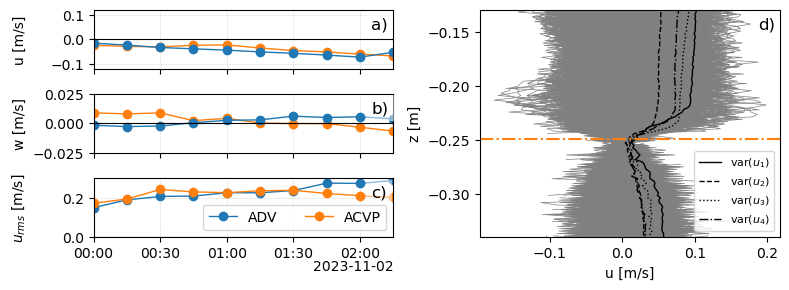

In [10]:
fig, ax = plt.subplots(3,2, sharex=True, figsize=[8, 3])
gs = ax[0, 1].get_gridspec()
# remove the underlying Axes
ax[0,1].remove()
ax[1,1].remove()
ax[2,1].remove()
axbig = fig.add_subplot(gs[:, -1])

jaleg=True
jav = False

# u velocities
ax[0,0].plot(adv.time, adv.ucm, marker='o', linewidth=1, linestyle='-', color='C1',label='ADV')
yp = ublab.um.coarsen(z=5).mean().isel(z=1).coarsen(time=3, boundary='pad').mean().interp_like(adv.time)
ax[0, 0].plot(yp.time, yp, label='UBLab', marker='o', linewidth=1, linestyle='-', color='C0')
ax[0,0].set_ylabel('u [m/s]')
ax[0,0].set_xlim([tvalid1, tvalid2])
ax[0,0].set_ylim([-0.12, 0.12])


# w velocities
ax[1, 0].plot(adv.time, adv.w.mean(dim='N'), label=r'$\left<\right>_{15min}$', marker='o', linewidth=1, linestyle='-', color='C1')
yp = ublab.wm.coarsen(z=5).mean().isel(z=1).coarsen(time=3, boundary='pad').mean().interp_like(adv.time)
ax[1, 0].plot(yp.time, yp, marker='o', linewidth=1, linestyle='-', color='C0')   

ax[1,0].set_ylabel('w [m/s]')
ax[1,0].set_ylim([-0.025, 0.025])

# std
ax[2, 0].plot(adv.time, adv.sig, label='ADV', marker='o', linewidth=1)
ax[2, 0].plot(ublab_skas.t, ublab_skas.sig.isel(z=5), label='ACVP', marker='o', linewidth=1)

ax[2,0].set_ylabel(r'$u_{rms}$ [m/s]' )
ax[2,0].set_ylim(0, 0.3)
ax[2,0].legend(ncol=2)


for axi in ax[:, 0]:
    # axi.set_ylim([-0.1, 0.1])
    axi.axhline(0, color='k', linewidth=0.8)

    axi.set_xlabel('')
    axi.grid(linestyle=':', color='grey', linewidth=0.5, alpha=0.5)
    axi.set_xlim([pd.to_datetime('20231102 00:00'), pd.to_datetime('20231102 02:15')])
    axi.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) 
    axi.set_xticks(pd.date_range(pd.to_datetime('20231102 00:00'),  pd.to_datetime('20231102 02:15'), freq=pd.to_timedelta('30T')))
    plt.title('')

from matplotlib.dates import DateFormatter
ax[2, 0].xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax[2, 0].text(1, -0.38, '2023-11-02',transform = ax[2, 0].transAxes, ha='right', va='top')

dsp = dsub.isel(time=range(1000))
# plt.figure(figsize=[5, 3])
dsp.v2.where(dsp.v2**2<0.2**2).where(dsp.snr2>3).plot.line(y='z', color='grey', linewidth=0.5, add_legend=False, ax=axbig);
dsp.v1.where(dsp.v1**2<0.2**2).where(dsp.snr1>3).std(dim='time').plot.line(y='z', linewidth=1, add_legend=True, label='var($u_1$)', color='k', ax=axbig);
dsp.v2.where(dsp.v2**2<0.2**2).where(dsp.snr2>3).std(dim='time').plot.line(y='z', linewidth=1, add_legend=True, label='var($u_2$)', linestyle='--', color='k', ax=axbig);
dsp.v3.where(dsp.v3**2<0.2**2).where(dsp.snr3>3).std(dim='time').plot.line(y='z', linewidth=1, add_legend=True, label='var($u_3$)', linestyle=':', color='k', ax=axbig);
dsp.v4.where(dsp.v4**2<0.2**2).where(dsp.snr4>3).std(dim='time').plot.line(y='z', linewidth=1, add_legend=True, label='var($u_4$)', linestyle='-.', color='k', ax=axbig);
axbig.set_ylim([-0.34, -0.13])
axbig.set_xlabel('u [m/s]')
axbig.set_ylabel('z [m]')

z_zb4 = ((z1q95m+z2q95m+z3q95m+z4q95m)/4).rename({'time':'t'})
axbig.axhline(z_zb4.sel(t=dsp.time[500], method='nearest'), c='C1', linestyle='-.')

axbig.legend(fontsize=8, loc='lower right')

import matplotlib.transforms as mtransforms
trans = mtransforms.ScaledTranslation(-16 / 72, -5 / 72, fig.dpi_scale_trans)
for label, axi in zip(['a)', 'b)', 'c)'], ax[:,0]):
    t = axi.text(1, 1.0, label, transform=axi.transAxes + trans,
            fontsize='large', verticalalignment='top')
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='None'))
t = axbig.text(1, 1.0, 'd)', transform=axbig.transAxes + trans,
        fontsize='large', verticalalignment='top')
t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='None'))
fig.align_ylabels()
fig.tight_layout()

plt.savefig(os.path.join(plotFilePath, 'ACVP_methodology.png'), dpi=200, bbox_inches='tight')

In [15]:
z_zb3 =  ((z1q95m+z2q95m+z3q95m+z4q95m)/4).rename({'time':'t'}).drop_vars(['quantile']).rolling(t=6*5, center='True').median()

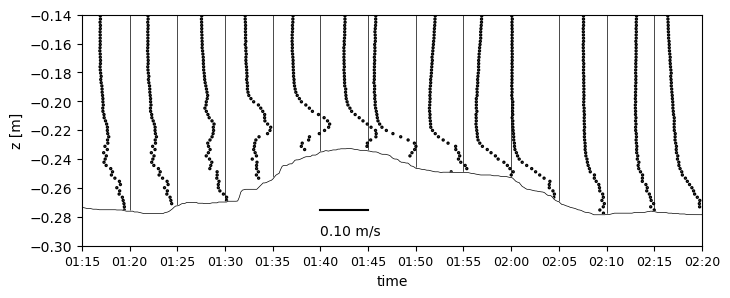

In [16]:
from field_visit_SEDRIB.funcs import *
dsp = ublab.rename({'um':'u_cross'})

fig, ax = ublab_profiles3_u(dsp, z_zb3, var='u_cross', **{'vmin': -0.2, 'vmax': 0.2, 'cmap': 'RdBu'}, timestamps=['00:25','00:30','00:35','00:40','00:45','00:50','00:55','01:00','01:05', '01:10','01:15', '01:20', '01:25','01:30','01:35','01:40','01:45','01:50','01:55','02:00','02:05', '02:10','02:15', '02:20'], factor=3, coarsenfac=1)
# tvalid1d = (pd.to_datetime('20231102 00:15')-pd.to_datetime('20231102 00:15'))/pd.to_timedelta('1s')
tvalid1d = (pd.to_datetime('20231102 01:15')-pd.to_datetime('20231102 00:15'))/pd.to_timedelta('1s')
tvalid2d = (tvalid2-pd.to_datetime('20231102 00:15'))/pd.to_timedelta('1s')
ax.set_xlim([tvalid1d, tvalid2d])
ax.set_xlabel('time')
ax.xaxis.set_tick_params(labelsize=9)
ax.set_ylim([-0.30, -0.14])
plt.savefig(os.path.join(plotFilePath, 'nearbed_flow_5min.png'), dpi=200, bbox_inches='tight')